In [9]:
# https://www.pywhy.org/dowhy/v0.10.1/user_guide/causal_tasks/estimating_causal_effects/index.html

# Estimating the causal effect requires four steps:

# Model a causal inference problem using assumptions.

#     Identify an expression for the causal effect under these assumptions (“causal estimand”).
#     Estimate the expression using statistical methods such as matching or instrumental variables.
#     Finally, verify the validity of the estimate using a variety of robustness checks.

# This workflow is captured by four key verbs in DoWhy:

#     model (CausalModel or graph)
#     identify (identify_effect)
#     estimate (estimate_effect)
#     refute (refute_estimate)


#https://www.pywhy.org/dowhy/v0.10.1/example_notebooks/dowhy_simple_example.html#

In [33]:
import networkx as nx
import pandas as pd
from dowhy import gcm
from dowhy import CausalModel
import numpy as np
import matplotlib.pyplot as plt

from dowhy.utils import plot, bar_plot

In [35]:
#Treat dataset

#Import data 
# data = pd.read_csv('../datasets/consolidated.csv',header=0, index_col=0)
data = pd.read_csv('./GenerateDatasets/consolidated.csv',header=0, index_col=0)
consolidated = pd.DataFrame(data)

consolidated = consolidated.drop(columns=['experiment', 'messageBandwidth'])#, 'gossipBandwidth'])#, 'messageDuplicated'])#, 'n_nodes', 'consensus', 'messageDuplicated'])
consolidated = consolidated.rename(columns={'topology':'top', 'totalBandwidth':'bandwidth', 'gossipBandwidth':'rpcs'})
consolidated['topology'] = 0
consolidated.loc[consolidated['top'] == 'general', 'topology'] = 1
consolidated = consolidated.loc[consolidated['bandwidth'] > 0]
consolidated = consolidated.drop(columns=['top'])
# consolidated.head(100)

#Rearrange columns according to nodes list
nodes = causal_graph.nodes

X = consolidated[['d', 'messageReceived', 'graft', 'prune', 'iwant', 'dlo', 'dhi', 'dscore', 'dlazy', 'ihave', 'dout', 
                  'gossipFactor', 'interval', 'topology', 'propagationTime', 'messageOverhead', 'bandwidth', 'rpcs']].to_numpy()

# X = consolidated.to_numpy()
# print(X)
consolidated.head(10)

,propagationTime,messageOverhead,messageReceived,graft,prune,iwant,ihave,bandwidth,rpcs,d,dlo,dhi,dscore,dlazy,dout,gossipFactor,interval,topology
0,1856.745902,3748.0,520.0,0.0,0.0,0.0,0.0,8512.0,4243.0,8,6,12,4,8,2,0.25,1.0,0
1,1979.913793,478.0,59.0,0.0,0.0,0.0,347.0,1234.0,697.0,8,6,12,4,8,2,0.25,1.0,0
2,1670.648148,3986.0,542.0,0.0,0.0,0.0,0.0,9027.0,4494.0,8,6,12,4,8,2,0.25,1.0,0
3,1710.708333,472.0,72.0,0.0,0.0,0.0,351.0,1259.0,715.0,8,6,12,4,8,2,0.25,1.0,0
4,1879.665217,3703.0,503.0,0.0,0.0,0.0,0.0,8369.0,4161.0,8,6,12,4,8,2,0.25,1.0,0
5,1723.305556,538.0,73.0,0.0,0.0,0.0,347.0,1385.0,774.0,8,6,12,4,8,2,0.25,1.0,0
6,1816.257895,3430.0,465.0,0.0,0.0,0.0,0.0,7774.0,3879.0,8,6,12,4,8,2,0.25,1.0,0
7,1556.234783,786.0,115.0,0.0,0.0,0.0,342.0,1956.0,1055.0,8,6,12,4,8,2,0.25,1.0,0
8,2597.587302,3456.0,460.0,0.0,0.0,0.0,0.0,7833.0,3913.0,8,6,12,4,8,2,0.25,1.0,0
9,1654.754386,779.0,115.0,0.0,0.0,0.0,343.0,1947.0,1053.0,8,6,12,4,8,2,0.25,1.0,0


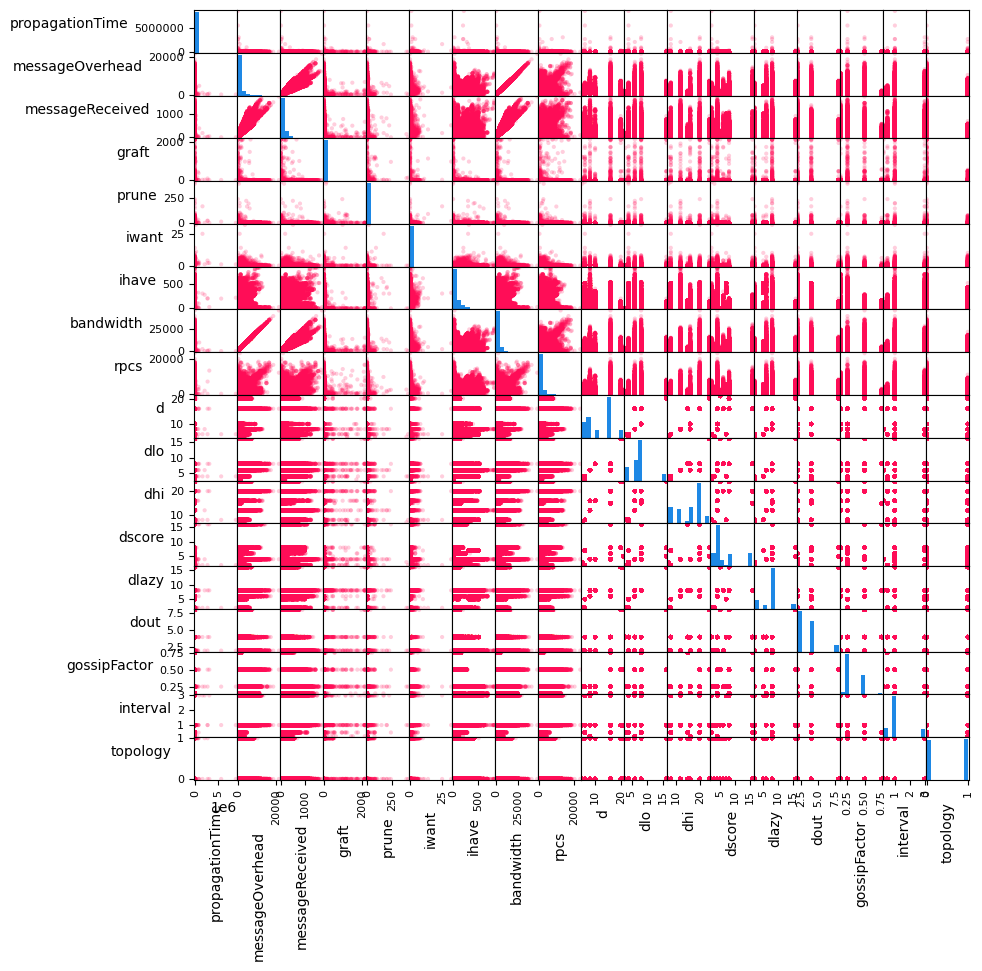

In [36]:
axes = pd.plotting.scatter_matrix(consolidated, figsize=(10, 10), c='#ff0d57', alpha=0.2, hist_kwds={'color':['#1E88E5']});
for ax in axes.flatten():
    ax.xaxis.label.set_rotation(90)
    ax.yaxis.label.set_rotation(0)
    ax.yaxis.label.set_ha('right')

In [37]:

causal_graph = nx.read_adjlist("./CausalDiscovery/pc.adjlist", create_using=nx.DiGraph)

gml_graph = "\n".join(nx.generate_gml(causal_graph))
# pos = nx.nx_agraph.graphviz_layout(causal_graph, prog="dot")
# nx.draw(causal_graph, pos, with_labels=True, node_size=1000)

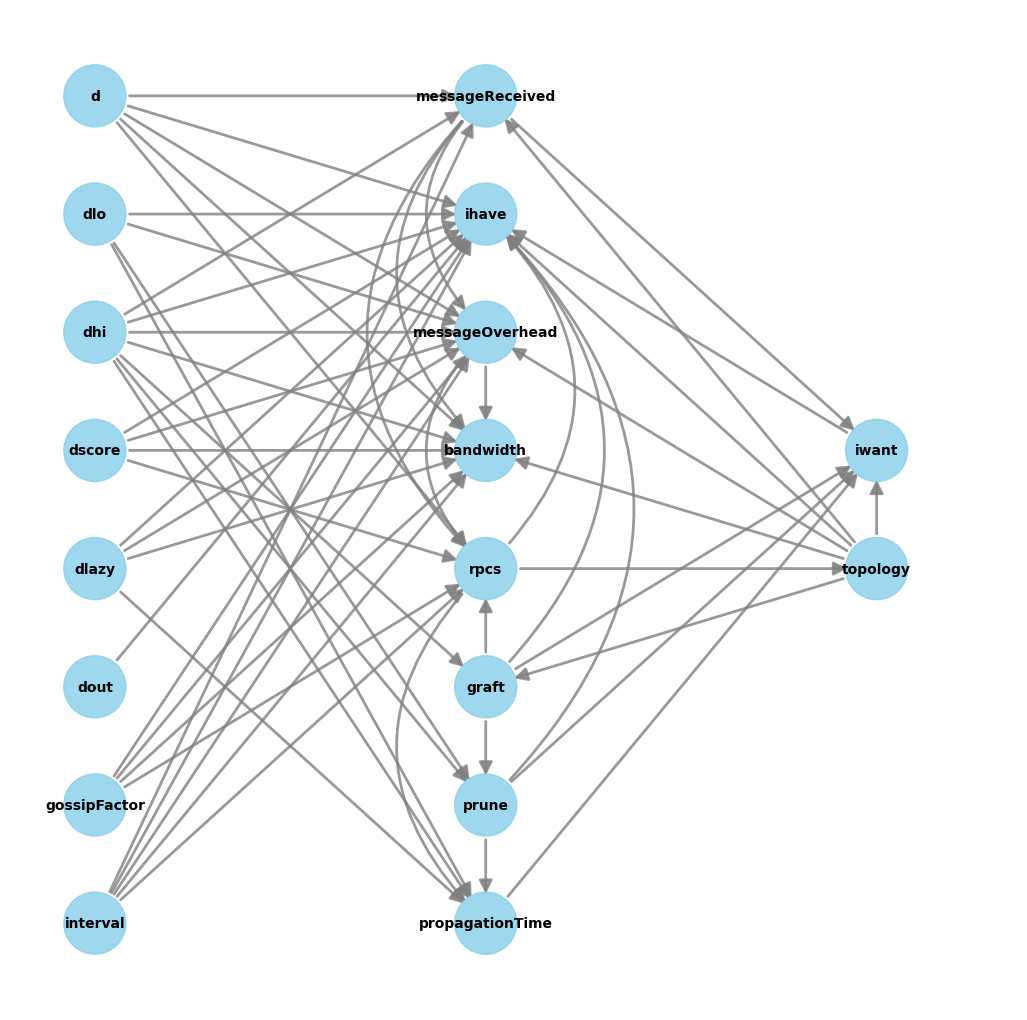

In [38]:
gcm.util.plot(causal_graph, figure_size=[13, 13])

In [39]:
#Fitting with mechanisms from the example: https://www.pywhy.org/dowhy/v0.10.1/example_notebooks/gcm_rca_microservice_architecture.html

from scipy.stats import halfnorm

causal_model = gcm.StructuralCausalModel(causal_graph)

# for node in causal_graph.nodes:
#     if len(list(causal_graph.predecessors(node))) > 0:
#         causal_model.set_causal_mechanism(node, gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor()))
#     else:
#         causal_model.set_causal_mechanism(node, gcm.ScipyDistribution(halfnorm))

# gcm.fit(causal_model, consolidated)
# print(gcm.evaluate_causal_model(causal_model, consolidated))

In [40]:
#Causal model didn't look good, so we try auto assign the causal mechanisms, according to 
#    https://aws.amazon.com/pt/blogs/opensource/root-cause-analysis-with-dowhy-an-open-source-python-library-for-causal-machine-learning/

# Automatically assign generative models to each node based on the given data
gcm.auto.assign_causal_mechanisms(causal_model, consolidated)

NetworkXUnfeasible: Graph contains a cycle or graph changed during iteration

In [ ]:
gcm.fit(causal_model, consolidated)
print(gcm.evaluate_causal_model(causal_model, consolidated))

In [ ]:

causal_graph = nx.read_adjlist("./CausalDiscovery/directLingam.adjlist", create_using=nx.DiGraph)

gml_graph = "\n".join(nx.generate_gml(causal_graph))\

gcm.util.plot(causal_graph, figure_size=[25, 25])

In [ ]:
causal_model = gcm.StructuralCausalModel(causal_graph)
gcm.auto.assign_causal_mechanisms(causal_model, consolidated)
gcm.fit(causal_model, consolidated)
print(gcm.evaluate_causal_model(causal_model, consolidated))

In [ ]:

causal_graph = nx.read_adjlist("./CausalDiscovery/ICALingam.adjlist", create_using=nx.DiGraph)

gml_graph = "\n".join(nx.generate_gml(causal_graph))\

gcm.util.plot(causal_graph, figure_size=[25, 25])

In [ ]:
causal_model = gcm.StructuralCausalModel(causal_graph)
gcm.auto.assign_causal_mechanisms(causal_model, consolidated)
gcm.fit(causal_model, consolidated)
print(gcm.evaluate_causal_model(causal_model, consolidated))

In [ ]:
#Causal graph
causal_graph = nx.DiGraph([('d', 'messageReceived'),
                           ('d', 'graft'),
                           ('d', 'prune'),
                           ('d', 'iwant'),
                           ('dlo', 'graft'),
                           ('dhi', 'prune'),
                           ('dscore', 'graft'),
                           ('dscore', 'prune'),
                           ('dlazy', 'iwant'),
                           ('dlazy', 'ihave'),
                           ('dout', 'graft'),
                           ('dout', 'prune'),
                           ('gossipFactor', 'iwant'),
                           ('gossipFactor', 'ihave'),
                           ('interval', 'graft'),
                           ('interval', 'prune'),
                           ('interval', 'iwant'),
                           ('interval', 'ihave'),
                           ('topology', 'graft'),
                           ('topology', 'prune'),
                           ('topology', 'propagationTime'),
                           ('topology', 'messageReceived'),
                           ('prune', 'graft'),
                           ('prune', 'propagationTime'),
                           ('messageReceived', 'messageOverhead'),
                           ('messageOverhead', 'bandwidth'),
                           ('ihave', 'bandwidth'),
                           ('iwant', 'bandwidth')
                         ])

gml_graph = "\n".join(nx.generate_gml(causal_graph))\

gcm.util.plot(causal_graph, figure_size=[25, 25])

In [ ]:
causal_model = gcm.StructuralCausalModel(causal_graph)
gcm.auto.assign_causal_mechanisms(causal_model, consolidated)
gcm.fit(causal_model, consolidated)
print(gcm.evaluate_causal_model(causal_model, consolidated))

In [ ]:

causal_graph = nx.read_adjlist("./CausalDiscovery/deci.adjlist", create_using=nx.DiGraph)

gml_graph = "\n".join(nx.generate_gml(causal_graph))\

gcm.util.plot(causal_graph, figure_size=[25, 25])

In [ ]:
causal_model = gcm.StructuralCausalModel(causal_graph)
gcm.auto.assign_causal_mechanisms(causal_model, consolidated)
gcm.fit(causal_model, consolidated)
print(gcm.evaluate_causal_model(causal_model, consolidated))